# Prediction Cancer With K-NN 


Este conjunto de dados contém as características de pacientes diagnosticados com câncer. O conjunto de dados contém um ID exclusivo para cada paciente, o tipo de câncer (diagnóstico), as características visuais do câncer e os valores médios dessas características.

📚 As principais características do conjunto de dados são as seguintes:

- `id`: Representa um ID exclusivo para cada paciente.

- `diagnosis`: Indica o tipo de câncer. Esta propriedade pode assumir os valores "M" (Maligno - Benigno) ou "B" (Benigno - Maligno).

- `radius_mean`, `texture_mean`, `perimeter_mean`, `area_mean`, `smoothness_mean`, `compactness_mean`, `concavity_mean`, `concave points_mean`: Representa os valores médios das características visuais do câncer.

Há também várias características categóricas em que os pacientes no conjunto de dados são rotulados com valores numéricos. Você pode examiná-las na área do Gráfico.

Outros recursos contêm intervalos específicos de valores médios dos recursos da imagem do câncer: `radius_mean`, `texture_mean`, `perimeter_mean`, `area_mean`, `smoothness_mean`, `compactness_mean`, `concavity_mean`, `concave points_mean`.

Cada um desses recursos é mapeado para uma tabela contendo o número de valores em um determinado intervalo. Você pode examinar as Tabelas do Gráfico.

Cada amostra contém o ID exclusivo do paciente, o diagnóstico de câncer e os valores médios das características visuais do câncer.

---

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np

from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score,GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve,classification_report

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier


## Data loading

In [2]:
try:
    df = pd.read_csv('../data/Cancer_Data.csv')
    display(df.head())
    print(df.shape)
except FileNotFoundError:
    print("Erro: 'Cancer_Data.csv' não encontrado. Certifique-se de que o arquivo existe no diretório atual.")
    df = None # Set df to None to indicate an error
except Exception as e:
    print(f"Ocorreu um erro inesperado: {e}")
    df = None

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


(569, 33)


## Data exploration

- Analisando os tipos de dados, valores ausentes e a distribuição da variável de diagnóstico; 

- Estatísticas descritivas e histogramas para características numéricas; 

- Matriz de correlação e Mapa de calor.

In [3]:
# 1. Tipos de dados e valores ausentes
print(df.info())
print("\nMissing values per column:\n", df.isnull().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

In [4]:
# Remover coluna 'Unnamed: 32' devido a todos os valores NaN
if 'Unnamed: 32' in df.columns:
    df = df.drop(columns=['Unnamed: 32'])


Diagnosis counts:
 diagnosis
B    357
M    212
Name: count, dtype: int64


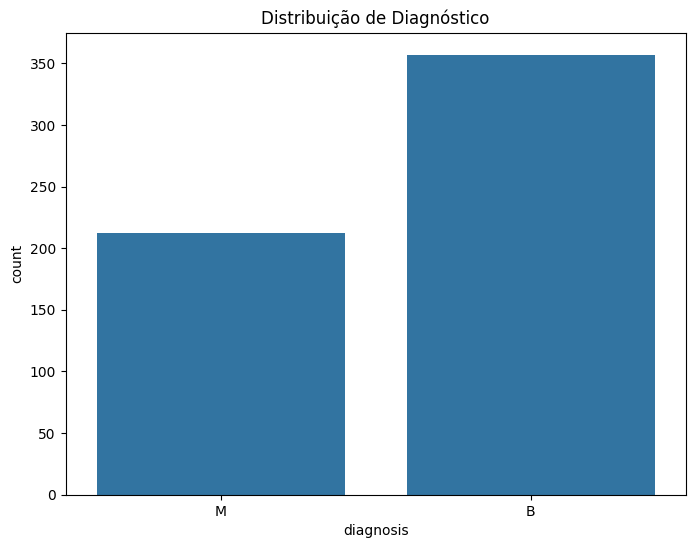

In [5]:
# 2. Distribuição de Diagnósticos

diagnosis_counts = df['diagnosis'].value_counts()
print("\nDiagnosis counts:\n", diagnosis_counts)
plt.figure(figsize=(8, 6))
sns.countplot(x='diagnosis', data=df)
plt.title('Distribuição de Diagnóstico')
plt.show()


Descriptive statistics for numerical features:
                  id  radius_mean  texture_mean  perimeter_mean    area_mean  \
count  5.690000e+02   569.000000    569.000000      569.000000   569.000000   
mean   3.037183e+07    14.127292     19.289649       91.969033   654.889104   
std    1.250206e+08     3.524049      4.301036       24.298981   351.914129   
min    8.670000e+03     6.981000      9.710000       43.790000   143.500000   
25%    8.692180e+05    11.700000     16.170000       75.170000   420.300000   
50%    9.060240e+05    13.370000     18.840000       86.240000   551.100000   
75%    8.813129e+06    15.780000     21.800000      104.100000   782.700000   
max    9.113205e+08    28.110000     39.280000      188.500000  2501.000000   

       smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
count       569.000000        569.000000      569.000000           569.000000   
mean          0.096360          0.104341        0.088799             0.048919

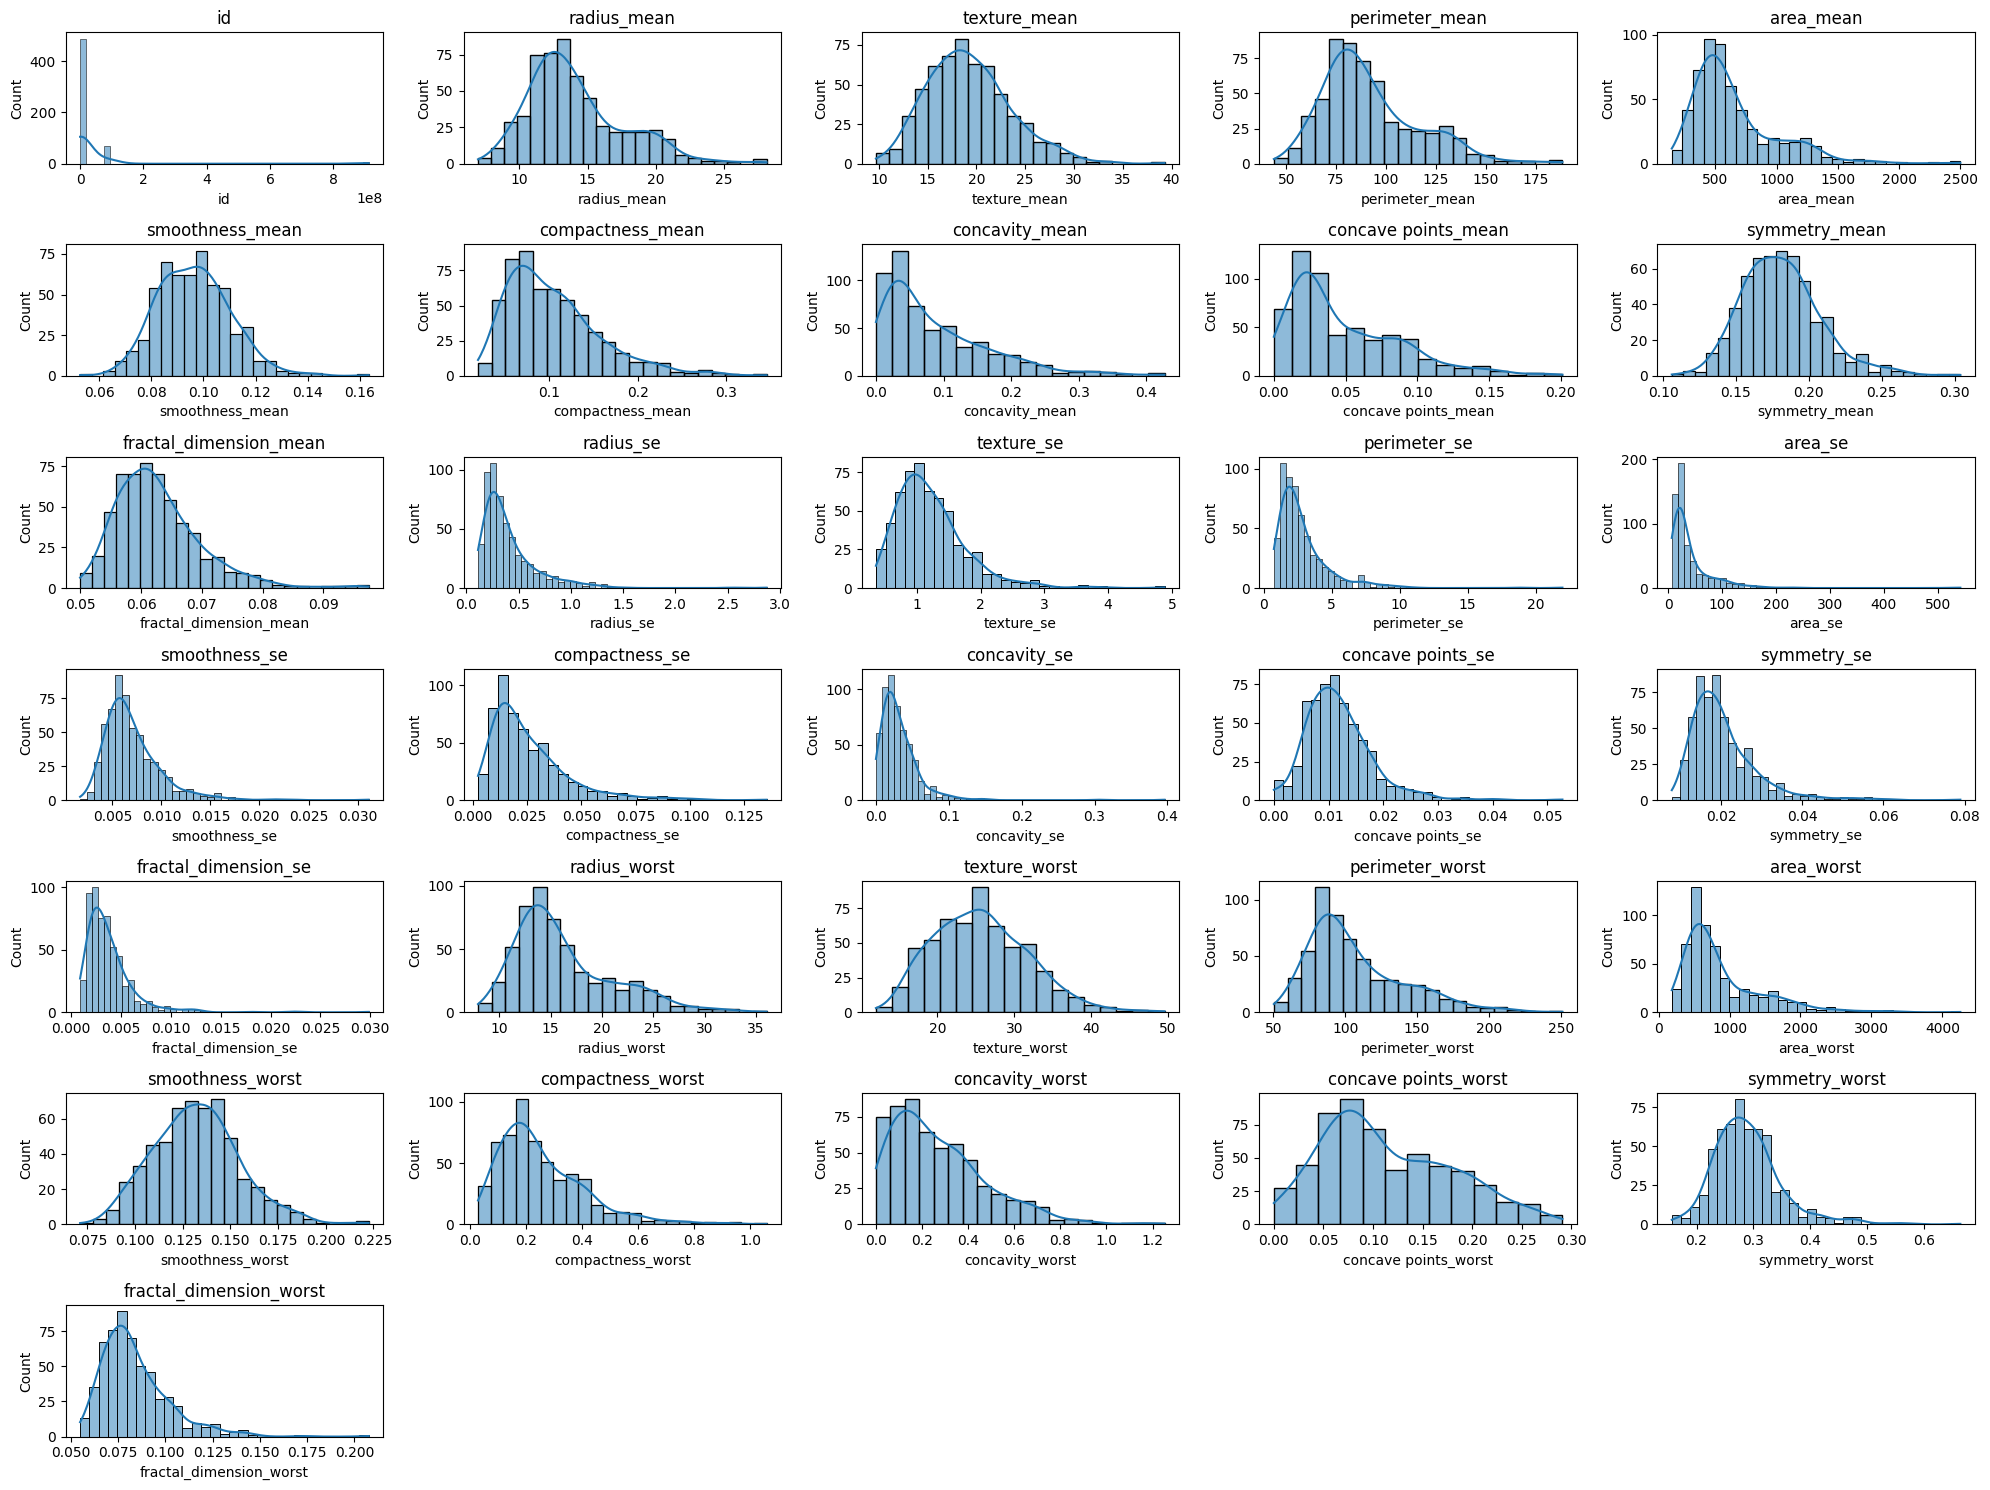

In [6]:
# 3. Estatísticas descritivas e histogramas para recursos numéricos
numerical_features = df.select_dtypes(include=['number'])
print("\nDescriptive statistics for numerical features:\n", numerical_features.describe())
plt.figure(figsize=(20, 15)) # Adjust figure size
for i, col in enumerate(numerical_features.columns):
    plt.subplot(7, 5, i + 1) # Create subplots
    sns.histplot(df[col], kde=True)
    plt.title(col)
    plt.tight_layout()
plt.show()

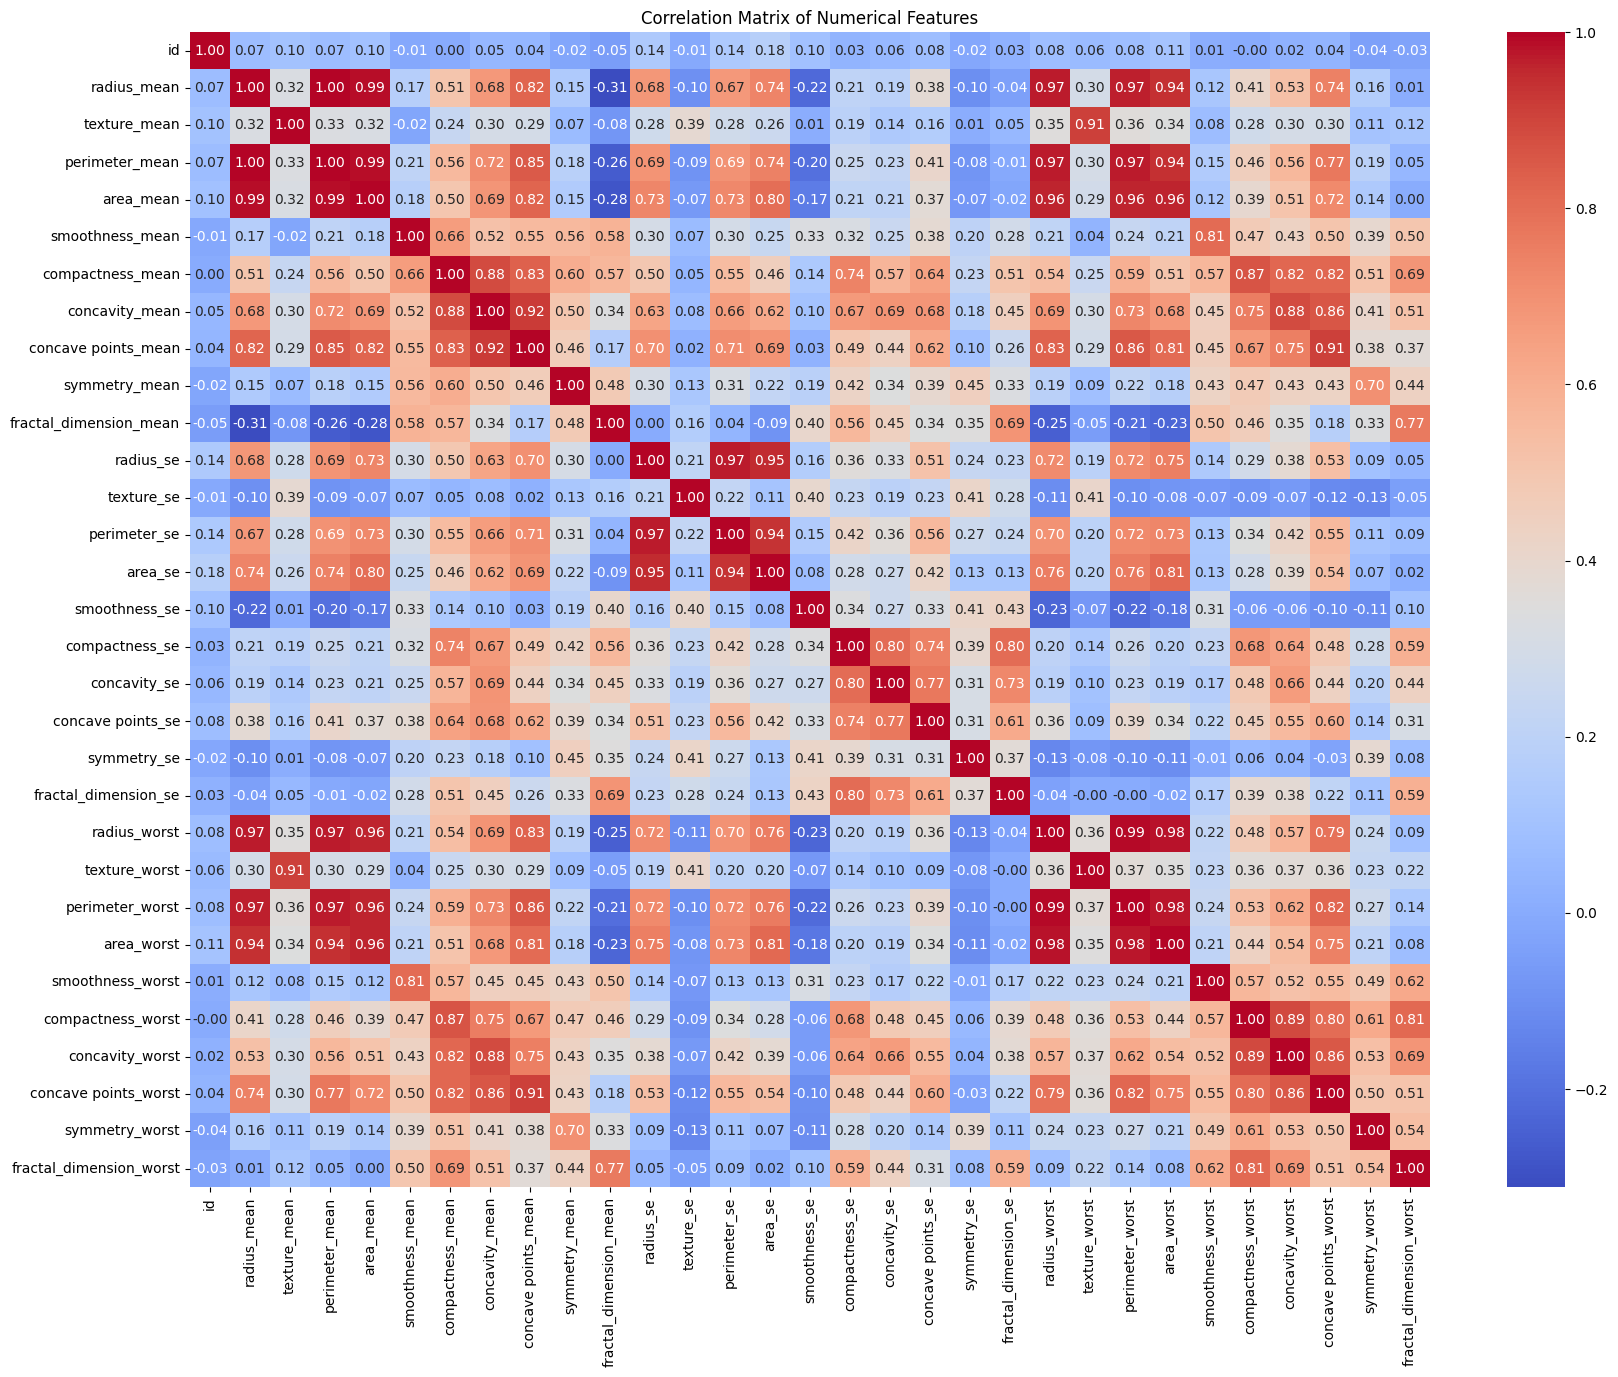

In [7]:
# 4. Matriz de correlação e mapa de calor
correlation_matrix = numerical_features.corr()
plt.figure(figsize=(20, 15))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numerical Features')
plt.show()

# Identificar características altamente correlacionadas (exemplo: acima de 0,9)
highly_correlated_features = correlation_matrix[correlation_matrix > 0.9]

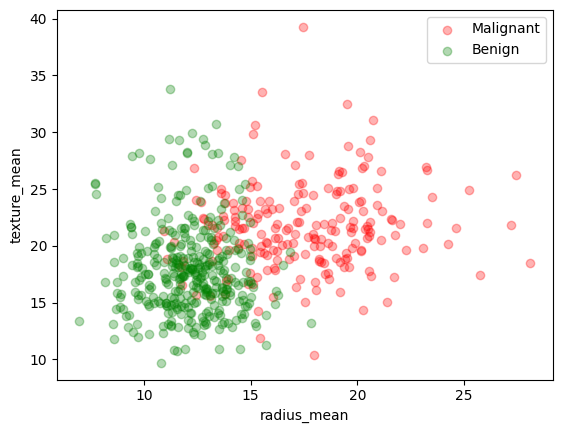

In [8]:
M = df[df.diagnosis == "M"] #O diagnóstico transfere todos os valores de M para M df
B = df[df.diagnosis == "B"] #O diagnóstico transfere todos os valores de B para B df

plt.scatter(M.radius_mean,M.texture_mean, color = "red", label = "Malignant", alpha = 0.3)
plt.scatter(B.radius_mean,B.texture_mean, color = "green", label = "Benign", alpha = 0.3)

plt.xlabel("radius_mean")
plt.ylabel("texture_mean")

plt.legend()

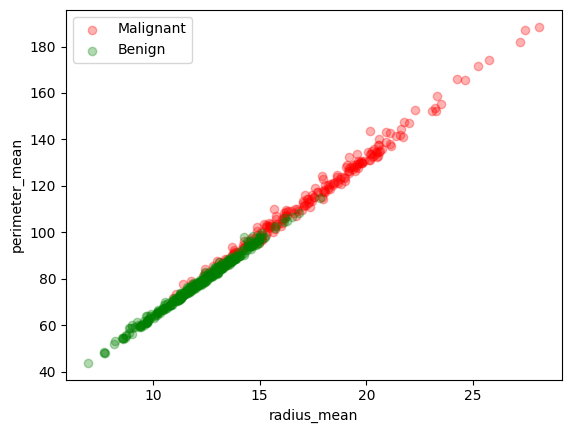

In [9]:
M = df[df.diagnosis == "M"] # O diagnóstico transfere todos os valores de M para M df
B = df[df.diagnosis == "B"] # O diagnóstico transfere todos os valores de B para B df

plt.scatter(M.radius_mean,M.perimeter_mean, color = "red", label = "Malignant", alpha = 0.3)
plt.scatter(B.radius_mean,B.perimeter_mean, color = "green", label = "Benign", alpha = 0.3)

plt.xlabel("radius_mean")
plt.ylabel("perimeter_mean")

plt.legend()

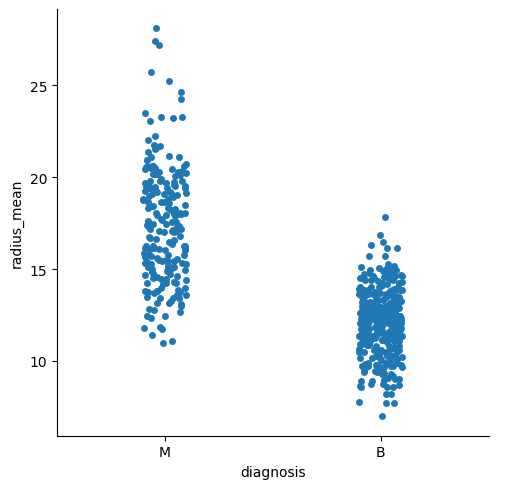

In [10]:
sns.catplot(x = "diagnosis", y = "radius_mean", data = df)

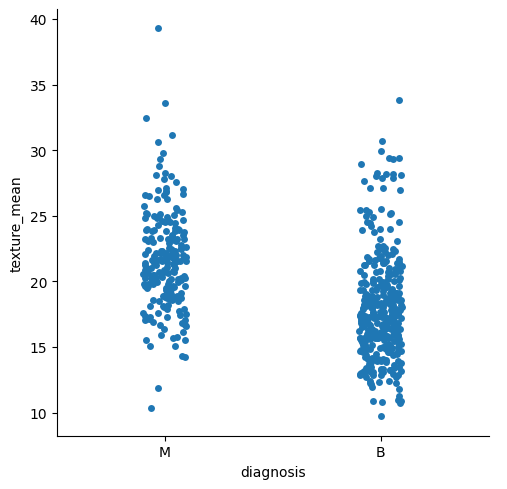

In [11]:
sns.catplot(x = "diagnosis", y = "texture_mean", data = df)

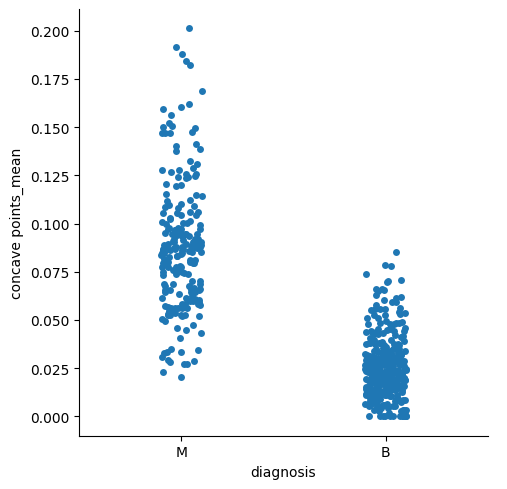

In [12]:
sns.catplot(x = "diagnosis", y = "concave points_mean", data = df)

### Resumir as descobertas em um relatório de redução
#### Relatório de Exploração de Dados de Câncer

**Formato dos Dados:** O conjunto de dados contém 569 linhas e 32 colunas.

**Distribuição do Diagnóstico:**
B    357
M    212

**Valores Ausentes:**
A coluna 'Unnamed: 32' continha apenas valores ausentes e foi descartada. Nenhum outro valor ausente foi encontrado no conjunto de dados.

**Características Numéricas:**
Estatísticas descritivas e distribuições foram geradas para todas as características numéricas. Os histogramas revelam potenciais valores discrepantes em diversas características. A inspeção visual dos histogramas é necessária para determinar se estes são realmente valores discrepantes e requerem tratamento adicional.

**Análise de Correlação:**
Uma matriz de correlação e um mapa de calor foram gerados para as características numéricas. O mapa de calor revela relações entre diferentes características. Características altamente correlacionadas (correlação > 0.9) são identificados na variável `highly_correlated_features`.

**Potenciais Outliers:**
Uma investigação mais aprofundada é necessária para confirmar a presença de outliers e determinar a melhor abordagem para lidar com eles (por exemplo, remoção, transformação). Os recursos com potenciais outliers incluem, entre outros, 'radius_mean', 'perimeter_mean', 'area_mean', 'radius_se', 'perimeter_se', 'area_se', 'radius_worst', 'perimeter_worst' e 'area_worst'. Esta é apenas uma observação preliminar, sendo necessária uma análise mais aprofundada para confirmá-los e tratá-los adequadamente.

## Data cleaning

Limpando os dados, manipulando valores discrepantes e eliminando a coluna 'id' irrelevante.

- IQR: Intervalo Interquartil, é uma medida estatística que indica a dispersão dos dados

In [13]:
# Recursos para lidar com outliers
features_with_outliers = ['radius_mean', 'perimeter_mean', 'area_mean', 'radius_se', 'perimeter_se', 'area_se', 'radius_worst', 'perimeter_worst', 'area_worst']

# Calcular IQR e identificar outliers para cada característica
for feature in features_with_outliers:
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Filtrar valores discrepantes
    df = df[(df[feature] >= lower_bound) & (df[feature] <= upper_bound)]

# Remova a coluna 'id' irrelevante
if 'id' in df.columns:
    df = df.drop(columns=['id'])

# Salvar em uma nova variável
df_cleaned = df

# DataFrame atualizado
display(df_cleaned.head())
print(df_cleaned.shape)
print(df_cleaned.columns)

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
3,M,11.42,20.38,77.58,386.1,0.1425,0.2839,0.24140,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.1730
5,M,12.45,15.70,82.57,477.1,0.1278,0.1700,0.15780,0.08089,0.2087,...,15.47,23.75,103.40,741.6,0.1791,0.5249,0.5355,0.1741,0.3985,0.1244
7,M,13.71,20.83,90.20,577.9,0.1189,0.1645,0.09366,0.05985,0.2196,...,17.06,28.14,110.60,897.0,0.1654,0.3682,0.2678,0.1556,0.3196,0.1151
8,M,13.00,21.82,87.50,519.8,0.1273,0.1932,0.18590,0.09353,0.2350,...,15.49,30.73,106.20,739.3,0.1703,0.5401,0.5390,0.2060,0.4378,0.1072
9,M,12.46,24.04,83.97,475.9,0.1186,0.2396,0.22730,0.08543,0.2030,...,15.09,40.68,97.65,711.4,0.1853,1.0580,1.1050,0.2210,0.4366,0.2075


(423, 31)
Index(['diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst'],
      dtype='object')


## Data visualization

Visualizando os dados limpos para obter mais insights.

Histogramas, gráficos de caixa e gráficos de dispersão para visualizar os dados limpos.

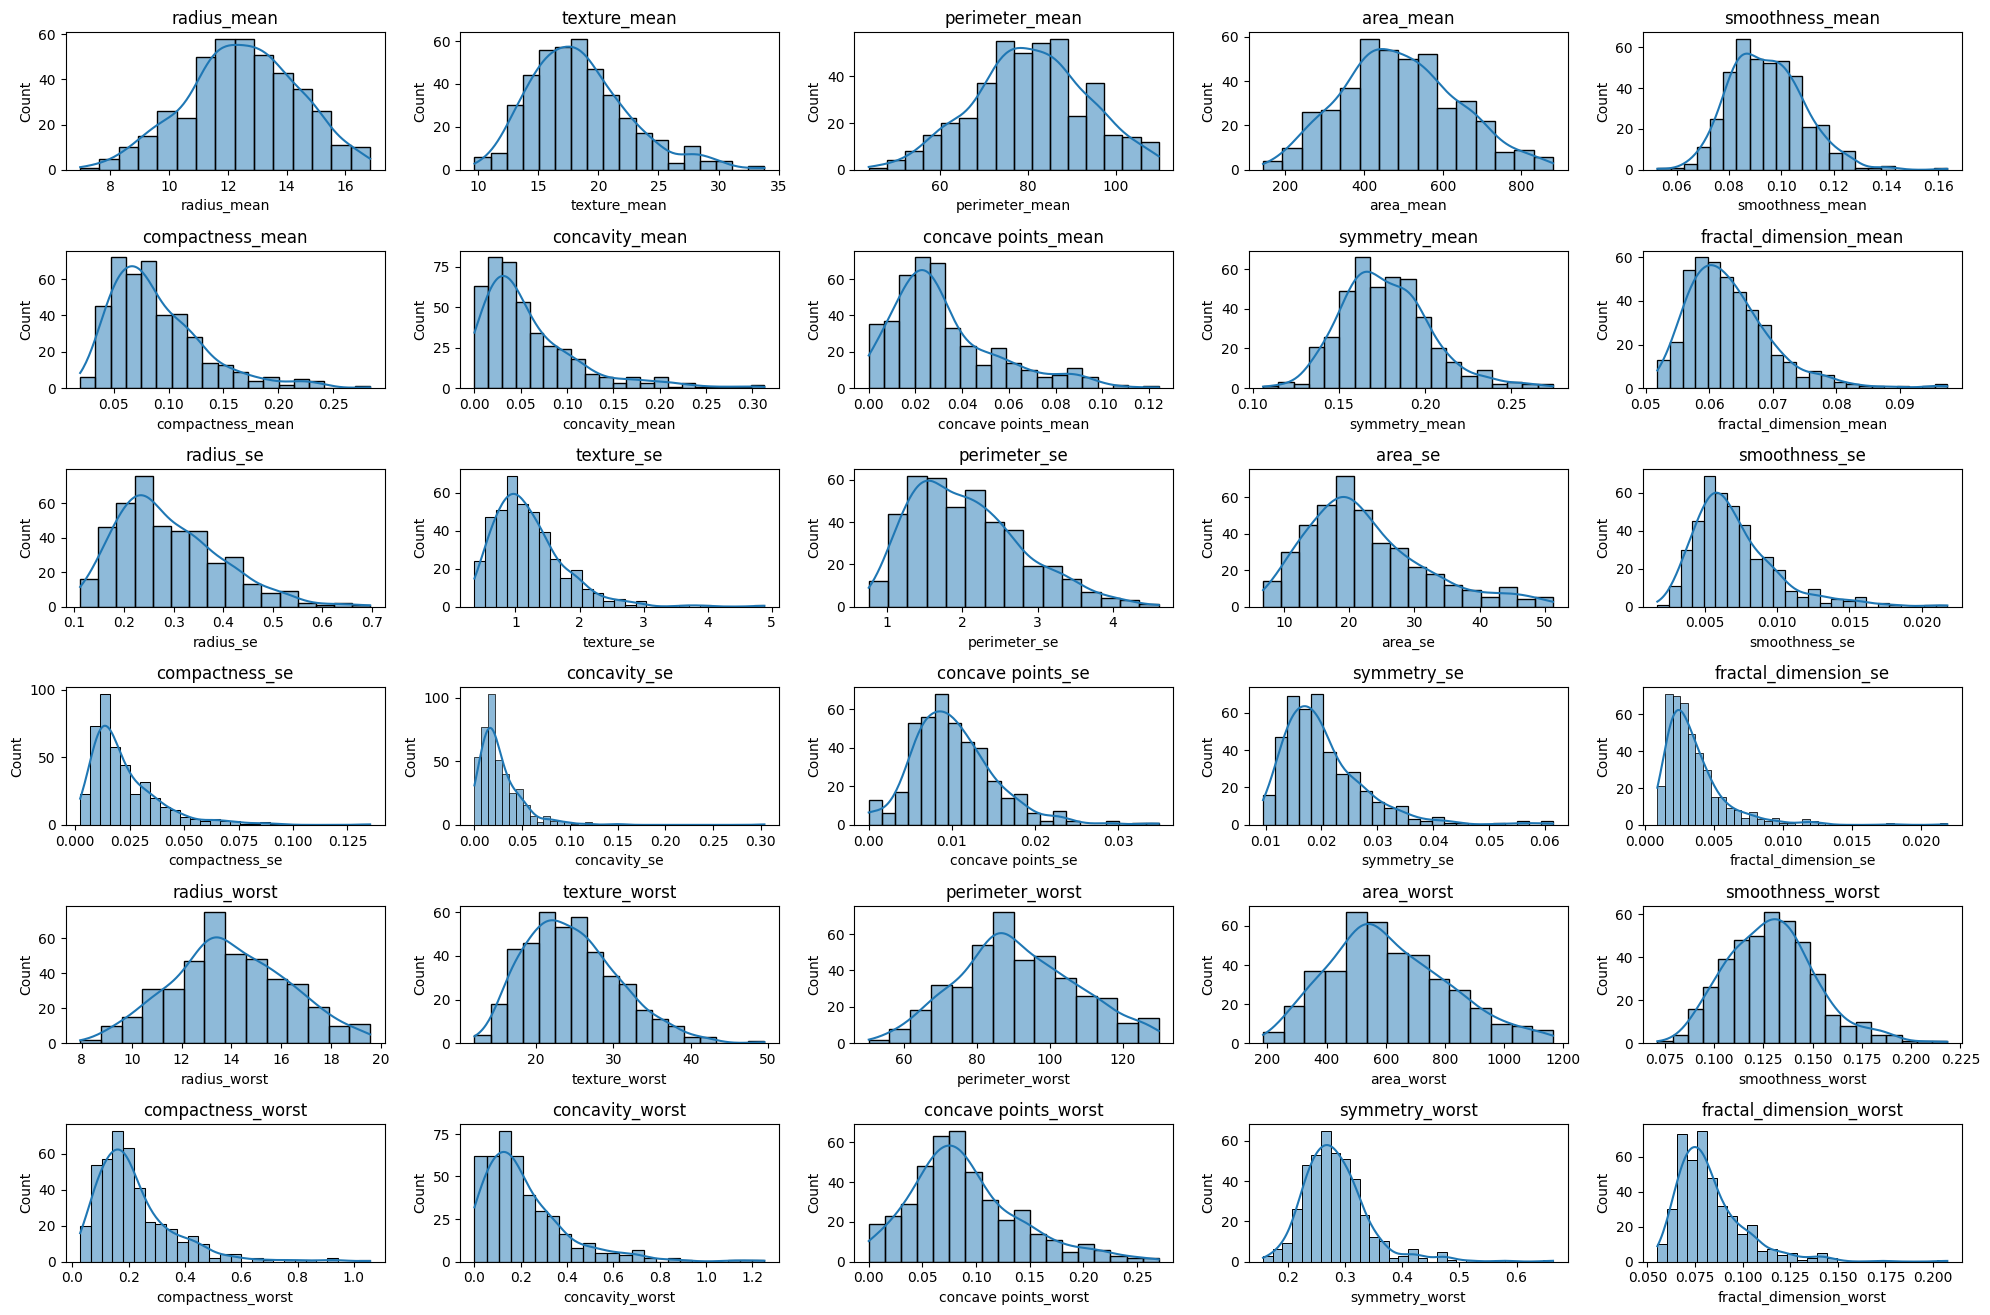

In [14]:
# Histograms
plt.figure(figsize=(20, 15))
for i, col in enumerate(df_cleaned.select_dtypes(include=['number']).columns):
    plt.subplot(7, 5, i + 1)
    sns.histplot(df_cleaned[col], kde=True)
    plt.title(col)
    plt.tight_layout()
plt.show()

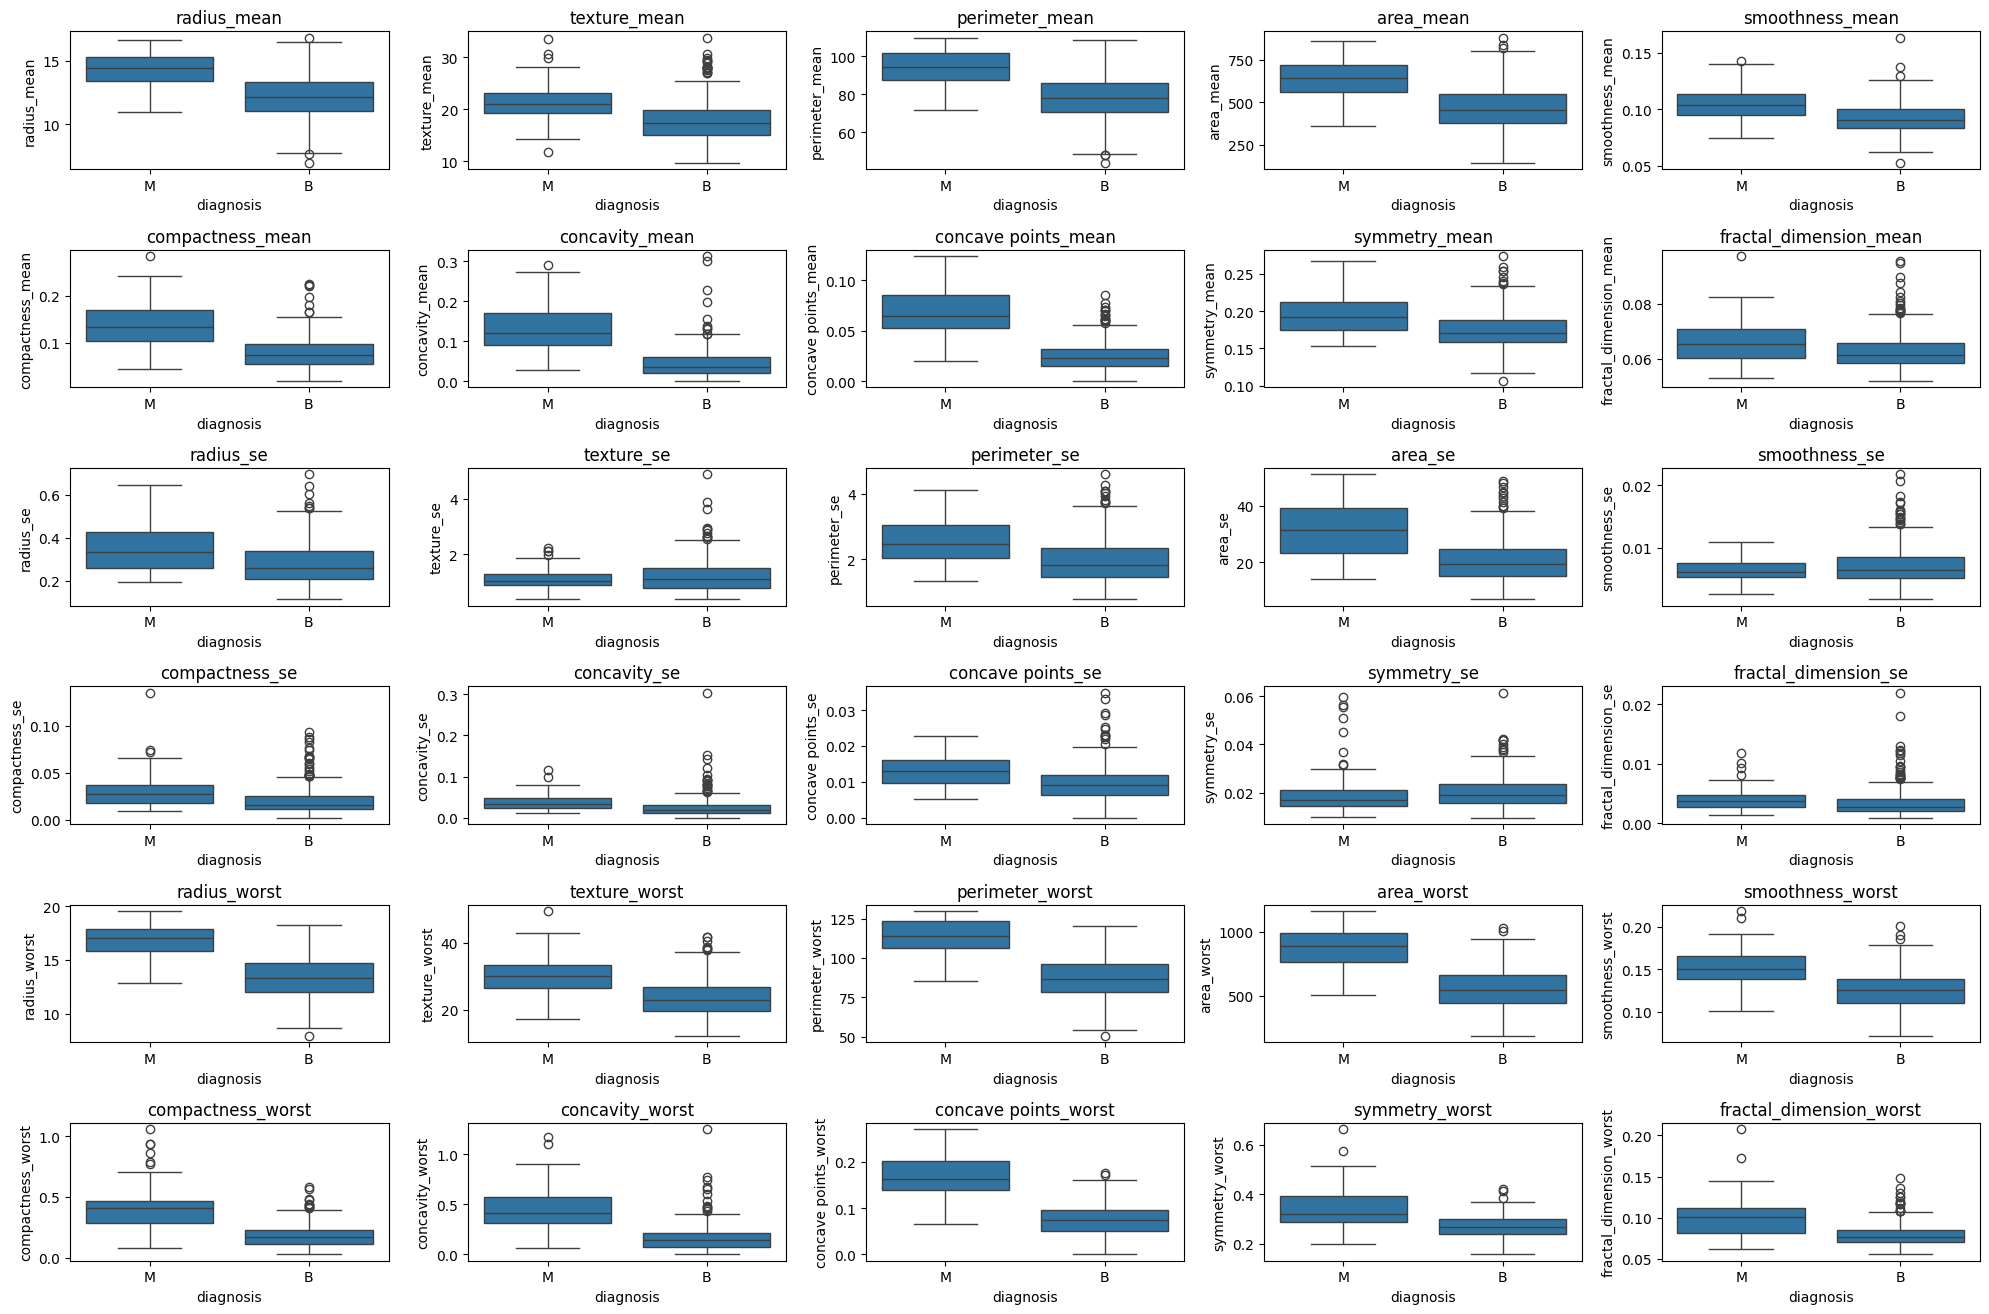

In [15]:
# Box plots
plt.figure(figsize=(20, 15))
for i, col in enumerate(df_cleaned.select_dtypes(include=['number']).columns):
    plt.subplot(7, 5, i + 1)
    sns.boxplot(x='diagnosis', y=col, data=df_cleaned)
    plt.title(col)
    plt.tight_layout()
plt.show()

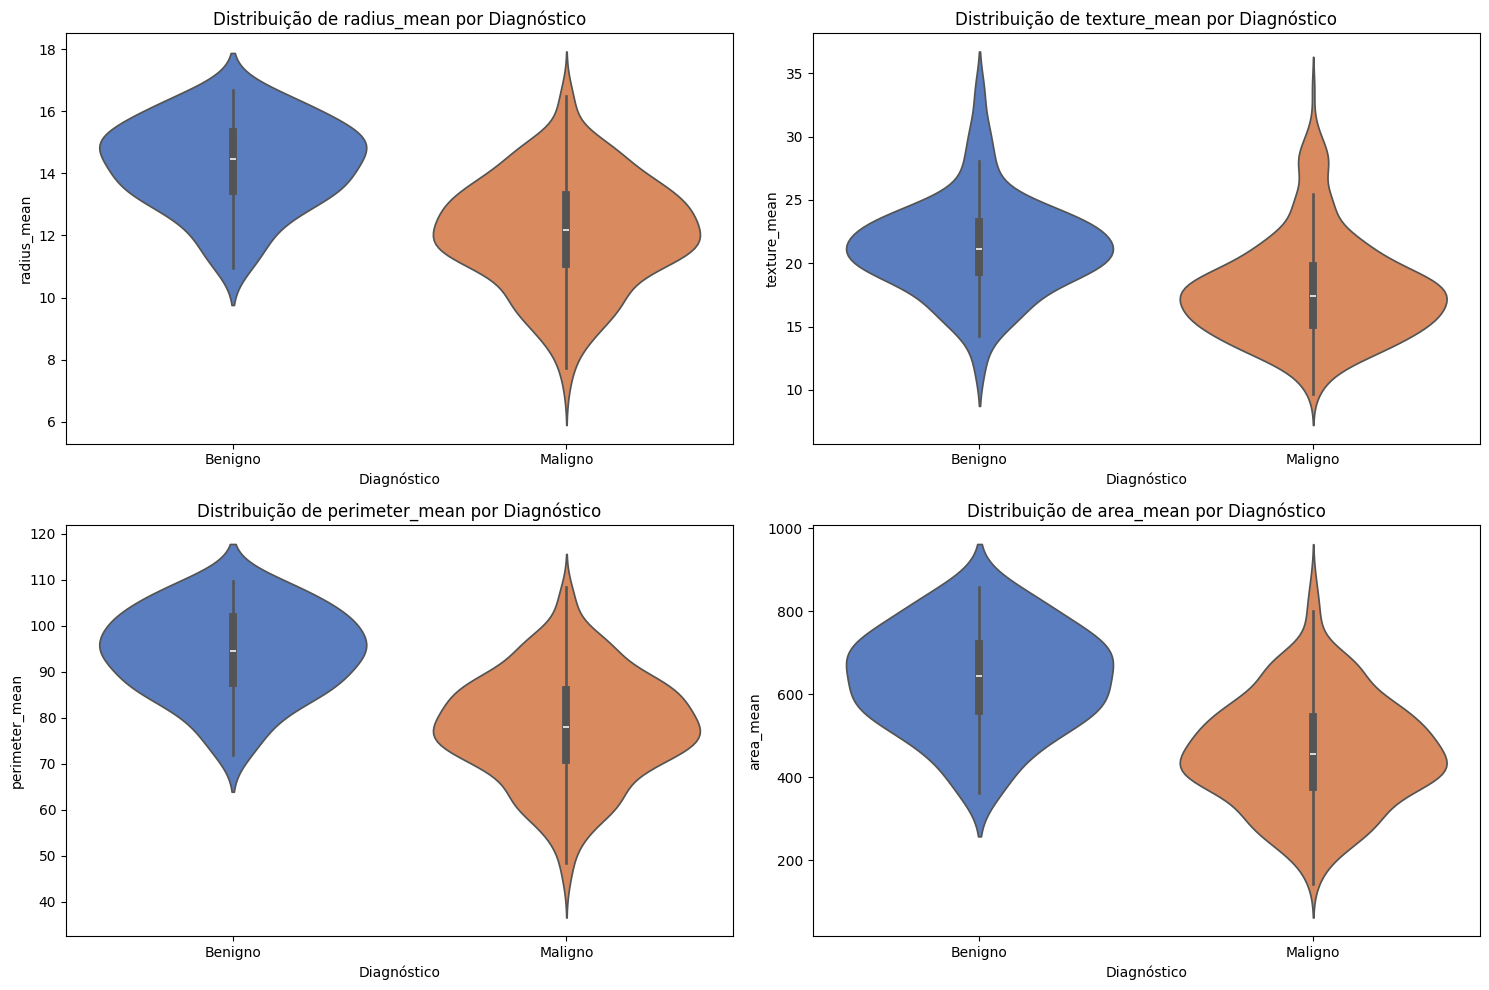

In [16]:
features = ['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean']
plt.figure(figsize=(15, 10))

for i, feature in enumerate(features):
    plt.subplot(2, 2, i + 1)
    sns.violinplot(x='diagnosis', y=feature, hue='diagnosis', data=df, palette='muted', legend=False)
    plt.title(f"Distribuição de {feature} por Diagnóstico")
    plt.xlabel('Diagnóstico')
    plt.ylabel(feature)
    plt.xticks(ticks=[0, 1], labels=['Benigno', 'Maligno'])

plt.tight_layout()
plt.show()

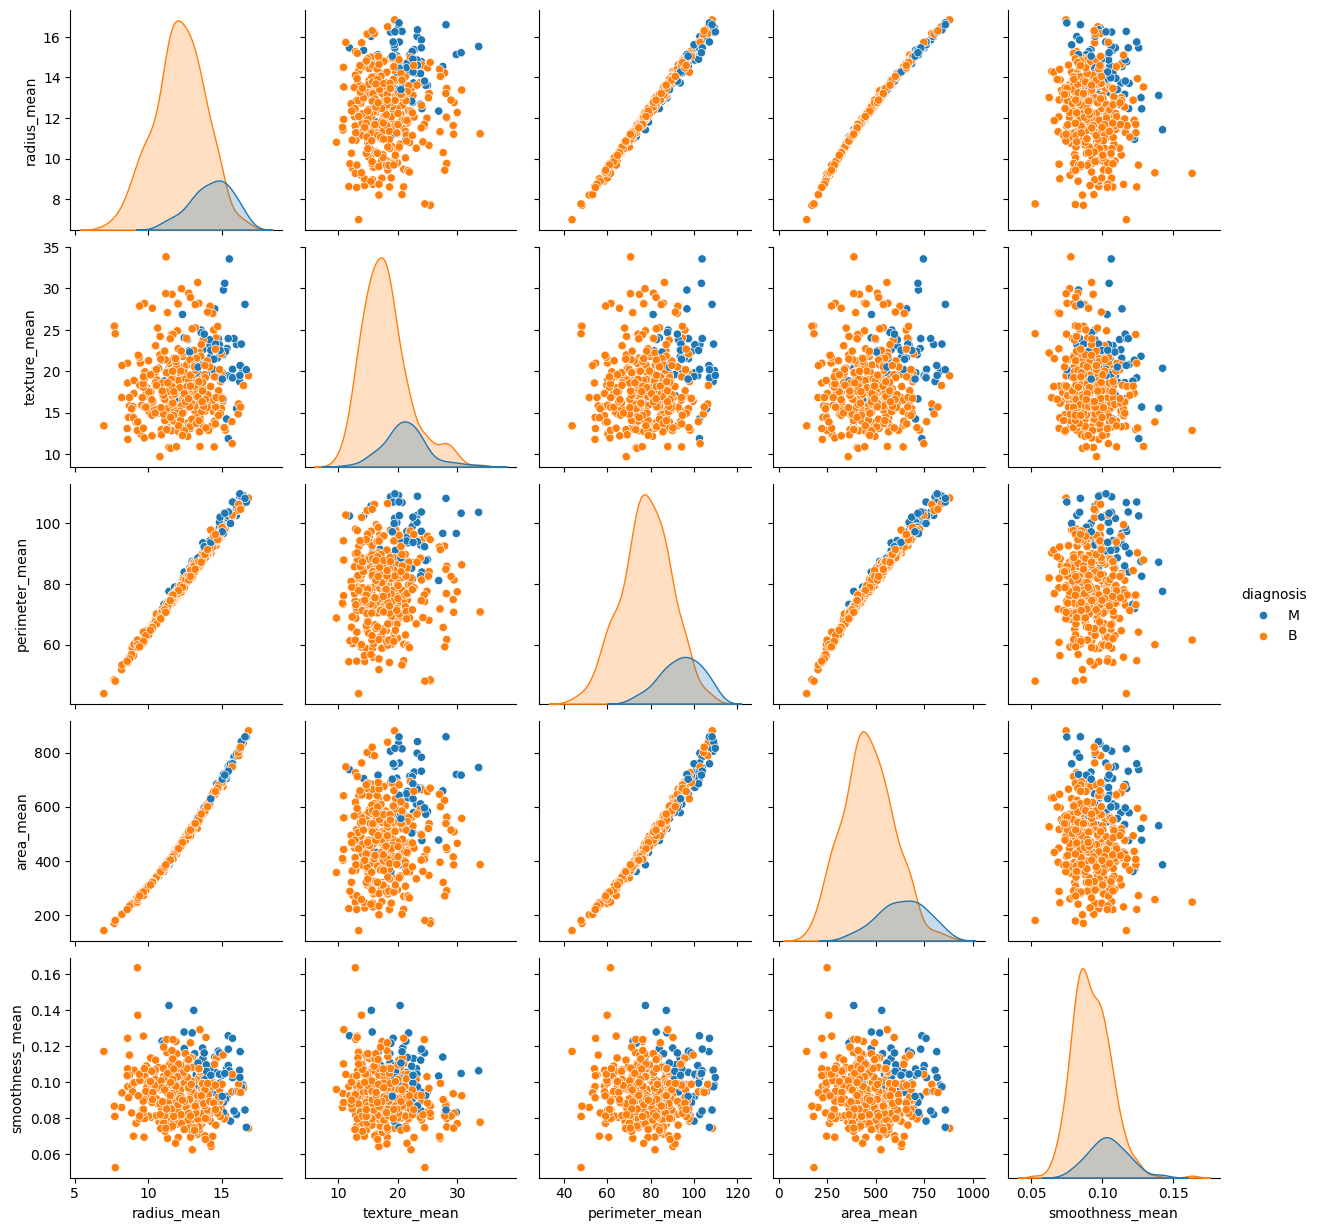

In [17]:
sns.pairplot(df_cleaned, hue='diagnosis', vars=['radius_mean', 'texture_mean', 'perimeter_mean','area_mean', 'smoothness_mean'])
plt.show()

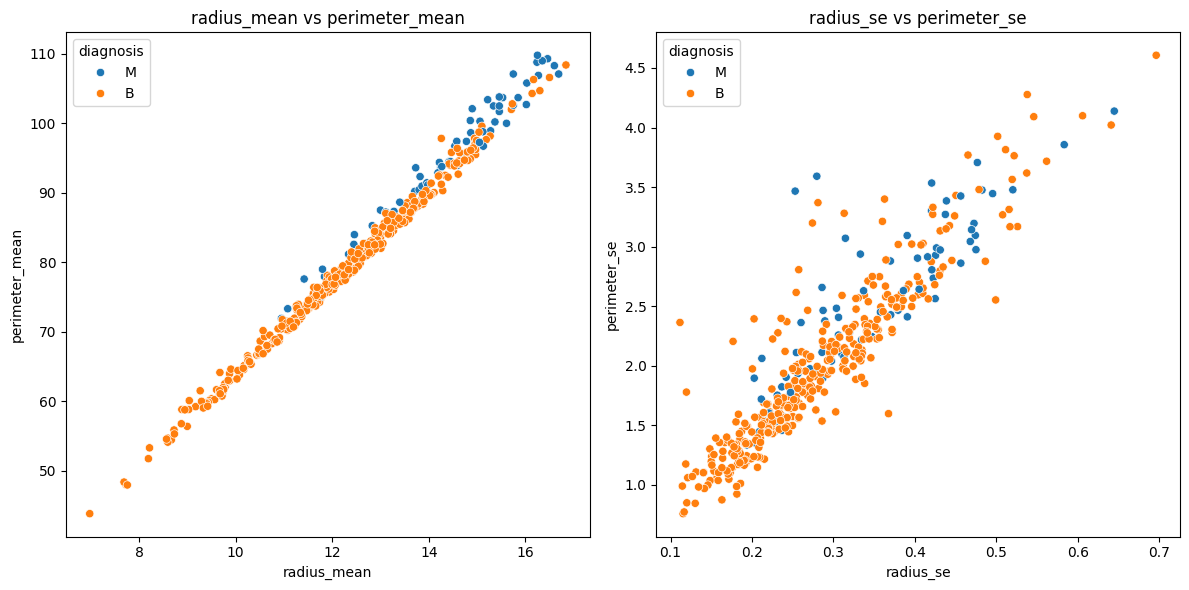

In [18]:
# Gráficos de dispersão (exemplo para recursos altamente correlacionados)
highly_correlated_pairs = [('radius_mean', 'perimeter_mean'), ('radius_se', 'perimeter_se')]

plt.figure(figsize=(12, 6))
for i, (col1, col2) in enumerate(highly_correlated_pairs):
  plt.subplot(1, len(highly_correlated_pairs), i+1)
  sns.scatterplot(x=col1, y=col2, hue='diagnosis', data=df_cleaned)
  plt.title(f'{col1} vs {col2}')
plt.tight_layout()
plt.show()

## Data preparation

- Preparando os dados para modelagem.

- Convertendo a coluna de diagnóstico em rótulos numéricos
- Separando os recursos e o alvo e dimensionando os recursos usando o MinMaxScaler


In [19]:
# Converter 'diagnóstico' em rótulos numéricos
df_cleaned['diagnosis'] = df_cleaned['diagnosis'].map({'B': 0, 'M': 1})

# Separar recursos (X) e variável de destino (y)
X = df_cleaned.drop('diagnosis', axis=1)
y = df_cleaned['diagnosis']

# Dimensionando os recursos usando MinMaxScaler
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

## Data splitting

- Dividir os dados escalonados em conjuntos de treinamento e teste.
- Dividindo os dados dimensionados em conjuntos de treinamento e teste usando train_test_split.

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

## Feature engineering

- Explorando potenciais técnicas de engenharia de recursos para melhorar o desempenho do modelo.
- Criando termos de interação e recursos polinomiais
- Avaliando o desempenho do modelo com e sem esses recursos projetados.

In [21]:
# Identificando características altamente correlacionadas
correlated_features = [('radius_mean', 'perimeter_mean'), ('radius_se', 'perimeter_se')]
for col1, col2 in correlated_features:
    df_cleaned[f'{col1}_{col2}_interaction'] = df_cleaned[col1] * df_cleaned[col2]

# Polinomiais
numerical_features = df_cleaned.select_dtypes(include=['number']).drop('diagnosis', axis=1).columns
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(df_cleaned[numerical_features])
X_poly_df = pd.DataFrame(X_poly, columns=poly.get_feature_names_out(numerical_features))

# Target
X = df_cleaned.drop('diagnosis', axis=1)
y = df_cleaned['diagnosis']

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_poly_train, X_poly_test, y_poly_train, y_poly_test = train_test_split(X_poly_df, y, test_size=0.2, random_state=42)

# Escalonamento correto
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

scaler_poly = MinMaxScaler()
X_poly_train_scaled = scaler_poly.fit_transform(X_poly_train)
X_poly_test_scaled = scaler_poly.transform(X_poly_test)


# Modelos
model_original = LogisticRegression(max_iter=5000)
model_engineered = LogisticRegression(max_iter=5000)

cv_scores_original = cross_val_score(model_original, X_train_scaled, y_train, cv=5)
model_original.fit(X_train_scaled, y_train)
y_pred_original = model_original.predict(X_test_scaled)

cv_scores_engineered = cross_val_score(model_engineered, X_poly_train_scaled, y_poly_train, cv=5)
model_engineered.fit(X_poly_train_scaled, y_poly_train)
y_pred_engineered = model_engineered.predict(X_poly_test_scaled)

# Avaliação
def evaluate_model(y_true, y_pred, name):
    print(f"\n{name}")
    print(f"Accuracy : {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precision: {precision_score(y_true, y_pred):.4f}")
    print(f"Recall   : {recall_score(y_true, y_pred):.4f}")
    print(f"F1-Score : {f1_score(y_true, y_pred):.4f}")

evaluate_model(y_test, y_pred_original, "Original Features (Scaled)")
evaluate_model(y_poly_test, y_pred_engineered, "Engineered Features (Scaled)")

print(f"\nCross-val Original: {cv_scores_original}")
print(f"Cross-val Engineered: {cv_scores_engineered}")


Original Features (Scaled)
Accuracy : 0.9176
Precision: 0.9231
Recall   : 0.6667
F1-Score : 0.7742

Engineered Features (Scaled)
Accuracy : 0.9765
Precision: 1.0000
Recall   : 0.8889
F1-Score : 0.9412

Cross-val Original: [0.92647059 0.95588235 0.91176471 0.97014925 0.95522388]
Cross-val Engineered: [0.95588235 0.95588235 0.98529412 0.98507463 0.98507463]


## Model training

Treinando um classificador K-Nearest Neighbors (KNN) nos dados de treinamento.

- Treinado classificador KNN com diferentes valores de hiperparâmetros e fazer previsões no conjunto de teste.

In [22]:

# Inicializar e treinar o classificador KNN
knn_classifier = KNeighborsClassifier(n_neighbors=5)
knn_classifier.fit(X_train_scaled, y_train)

# fazer previsões sobre os dados de teste
y_pred = knn_classifier.predict(X_test_scaled)

## Model evaluation

Avaliando o desempenho do modelo KNN treinado.

- Avaliando o desempenho do modelo KNN usando várias métricas
- visualizando os resultados com uma matriz de confusão e uma curva ROC (mostra a relação entre a taxa de verdadeiros positivos (TPR) e a taxa de falsos positivos (FPR) em diferentes limiares de decisão). 

In [23]:
# Calculando métricas de avaliação
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")

Accuracy: 0.9529411764705882
Precision: 0.9375
Recall: 0.8333333333333334
F1-score: 0.8823529411764706


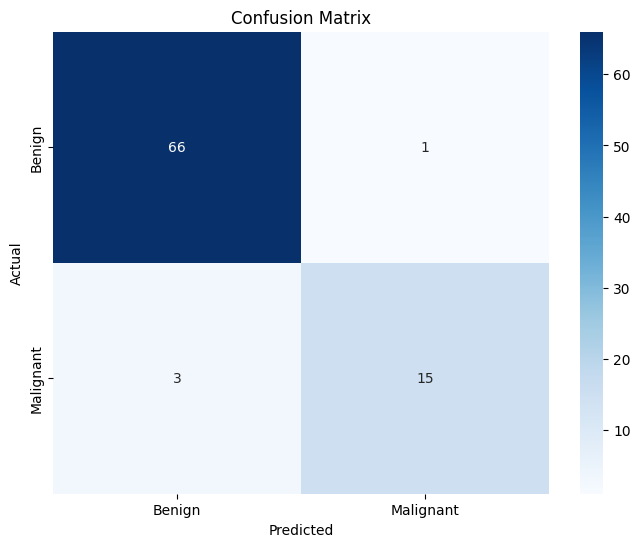

In [24]:
# Matriz de Confusão
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Benign', 'Malignant'], yticklabels=['Benign', 'Malignant'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

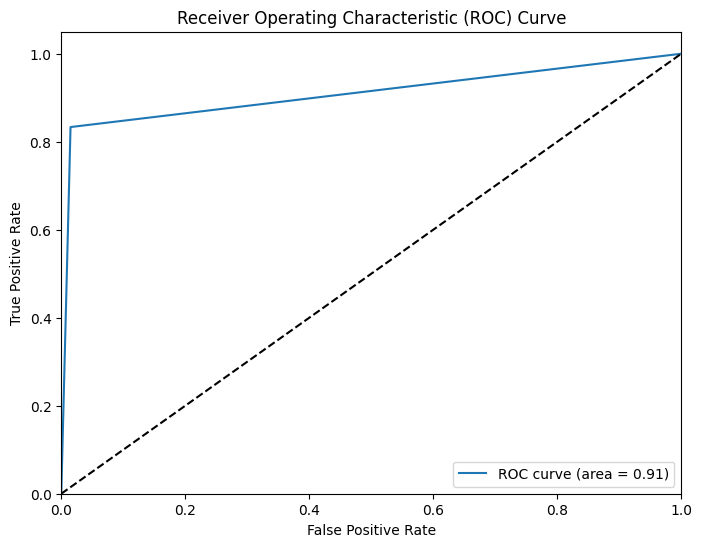

ROC AUC Score: 0.9092039800995025


In [25]:

# Curva ROC e AUC
try:
    roc_auc = roc_auc_score(y_test, y_pred)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')  # Random classifier line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()
    print(f"ROC AUC Score: {roc_auc}")
except ValueError:
    print("ROC AUC score is not defined in this case.")

Um AUC de 0.9092 indica que, em 90,92% das vezes, o modelo atribui uma probabilidade mais alta a uma amostra positiva do que a uma negativa.

## Model optimization

- Otimizando o modelo KNN ajustando o hiperparâmetro `n_neighbors` e explorando diferentes métricas de distância.


In [26]:
# Definindo a grade de parâmetros para KNN
param_grid = {
    'n_neighbors': range(1, 31),
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

# Inicializando classificador KNN
knn = KNeighborsClassifier()

# Executando GridSearchCV para KNN
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_scaled, y_train)

print("Best KNN parameters:", grid_search.best_params_)
print("Best KNN accuracy:", grid_search.best_score_)

# Avaliando o melhor modelo KNN no conjunto de teste
best_knn = grid_search.best_estimator_
y_pred_knn = best_knn.predict(X_test_scaled)
print("KNN Classification Report:\n", classification_report(y_test, y_pred_knn))

# Treinando e avaliar outros classificadores
classifiers = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'SVM': SVC(),
    'Decision Tree': DecisionTreeClassifier()
}

for name, clf in classifiers.items():
    cv_scores = cross_val_score(clf, X_train_scaled, y_train, cv=5)
    print(f"{name} cross-validation scores: {cv_scores}")
    clf.fit(X_train_scaled, y_train)
    y_pred = clf.predict(X_test_scaled)
    print(f"{name} Classification Report:\n", classification_report(y_test, y_pred))

Best KNN parameters: {'metric': 'manhattan', 'n_neighbors': 3}
Best KNN accuracy: 0.9526777875329238
KNN Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.99      0.96        67
           1       0.93      0.78      0.85        18

    accuracy                           0.94        85
   macro avg       0.94      0.88      0.91        85
weighted avg       0.94      0.94      0.94        85

Logistic Regression cross-validation scores: [0.92647059 0.95588235 0.91176471 0.97014925 0.95522388]
Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.99      0.95        67
           1       0.92      0.67      0.77        18

    accuracy                           0.92        85
   macro avg       0.92      0.83      0.86        85
weighted avg       0.92      0.92      0.91        85

SVM cross-validation scores: [0.94117647 0.94117647 0.95588235 0.970149

## Data visualization

Visualizando os resultados do modelo KNN e outros classificadores.

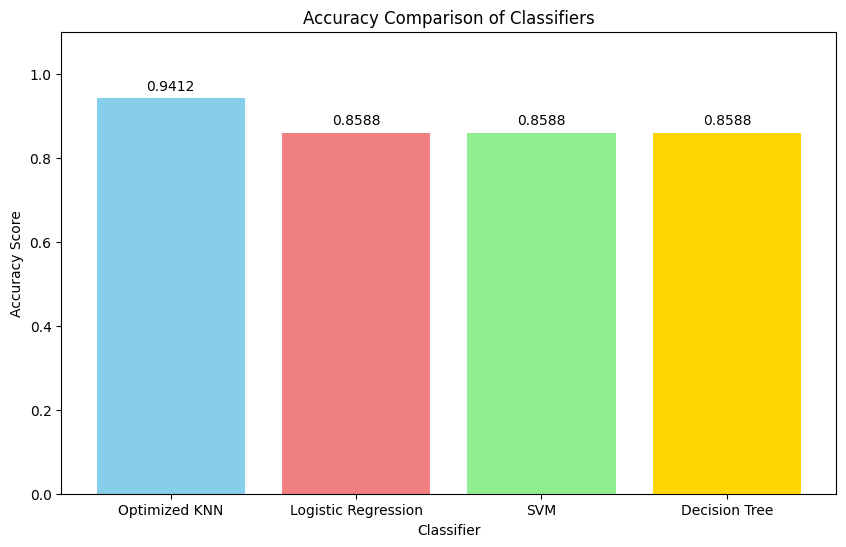

In [27]:

# 1. Gráfico de barras de comparação de precisão
model_names = ['Optimized KNN', 'Logistic Regression', 'SVM', 'Decision Tree']
accuracy_scores = [
    accuracy_score(y_test, y_pred_knn),
    accuracy_score(y_test, y_pred), # Logistic Regression
    accuracy_score(y_test, y_pred), # SVM
    accuracy_score(y_test, y_pred) # Decision Tree
]

plt.figure(figsize=(10, 6))
plt.bar(model_names, accuracy_scores, color=['skyblue', 'lightcoral', 'lightgreen', 'gold'])
plt.xlabel('Classifier')
plt.ylabel('Accuracy Score')
plt.title('Accuracy Comparison of Classifiers')
plt.ylim(0, 1.1) # Adjust y-axis limit to accommodate accuracy scores
for i, v in enumerate(accuracy_scores):
    plt.text(i, v + 0.02, str(round(v, 4)), ha='center')  # Add values above the bars
plt.show()

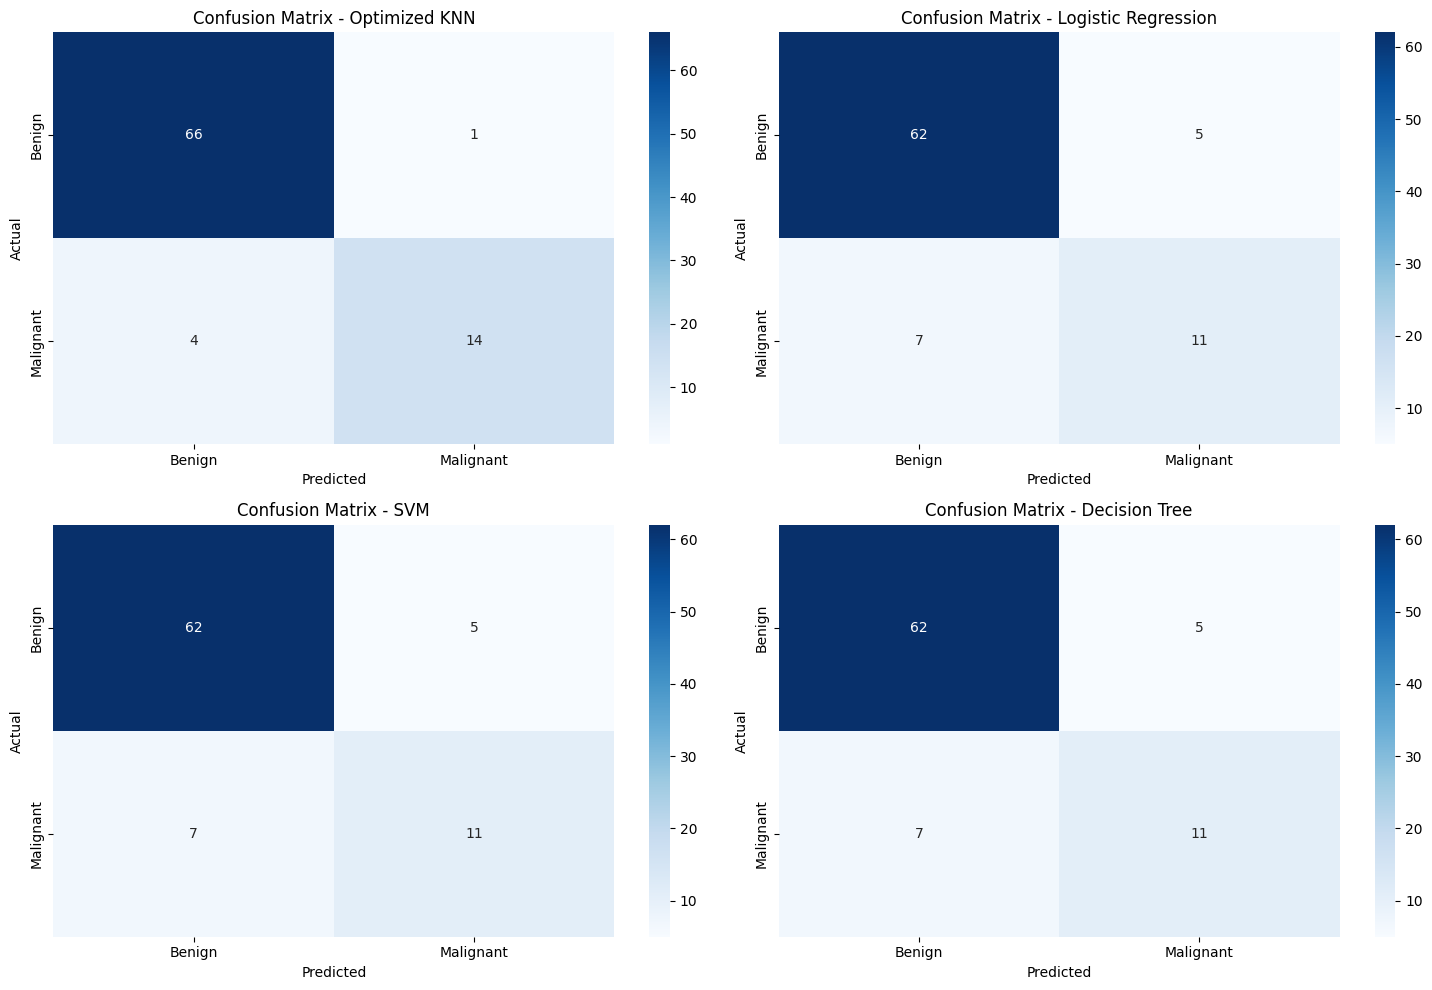

In [28]:
# 2. Matrizes de Confusão
models_predictions = {
    'Optimized KNN': y_pred_knn,
    'Logistic Regression': y_pred, # Logistic Regression
    'SVM': y_pred, # SVM
    'Decision Tree': y_pred # Decision Tree
}

plt.figure(figsize=(15, 10))
for i, (name, y_pred_model) in enumerate(models_predictions.items()):
    cm = confusion_matrix(y_test, y_pred_model)
    plt.subplot(2, 2, i + 1)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=['Benign', 'Malignant'], yticklabels=['Benign', 'Malignant'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {name}')
plt.tight_layout()
plt.show()

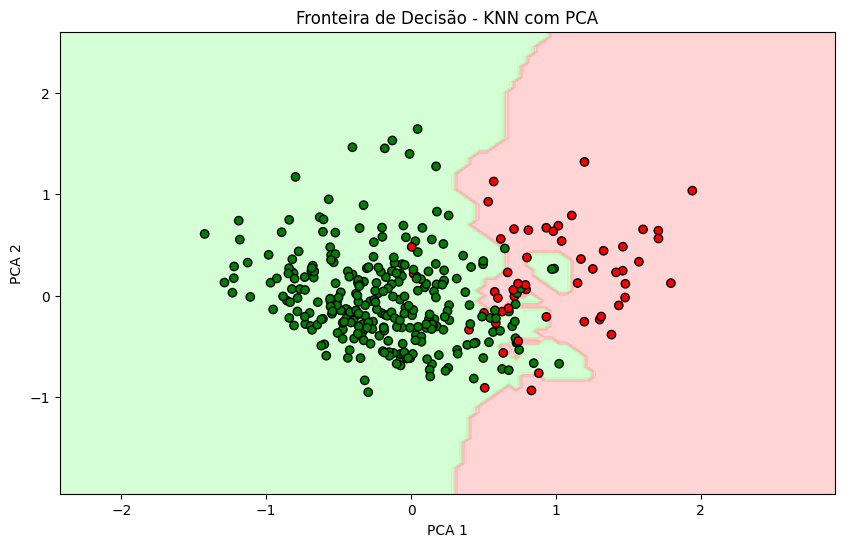

In [34]:
# Fronteira de Decisão (PCA)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_scaled)
knn_2d = KNeighborsClassifier(n_neighbors=grid_search.best_params_['n_neighbors'])
knn_2d.fit(X_pca, y_train)

x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.05), np.arange(y_min, y_max, 0.05))
Z = knn_2d.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(10, 6))
plt.contourf(xx, yy, Z, cmap=ListedColormap(['#AAFFAA', '#FFAAAA']), alpha=0.5)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_train, cmap=ListedColormap(['green', 'red']), edgecolor='k')
plt.title('Fronteira de Decisão - KNN com PCA')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.show()

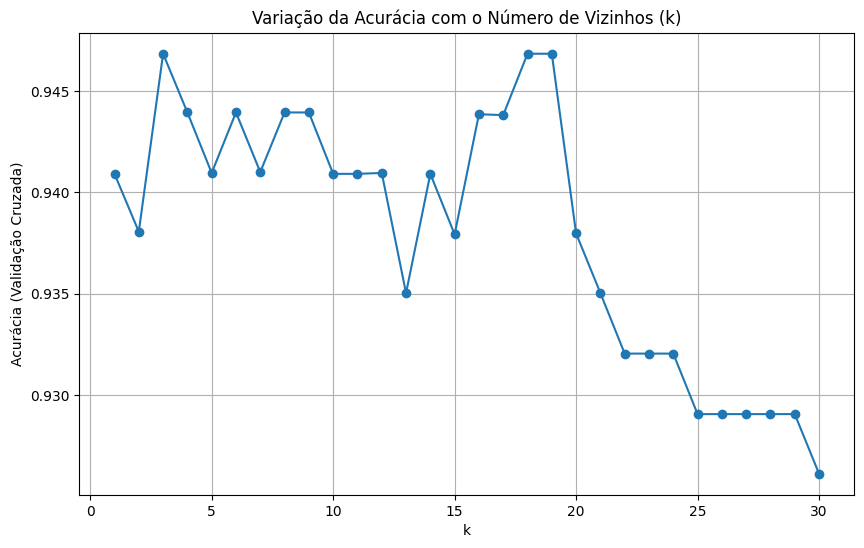

In [35]:

# Variação da Acurácia com k
k_range = range(1, 31)
accuracies = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train_scaled, y_train, cv=5, scoring='accuracy')
    accuracies.append(scores.mean())

plt.figure(figsize=(10, 6))
plt.plot(k_range, accuracies, marker='o')
plt.title('Variação da Acurácia com o Número de Vizinhos (k)')
plt.xlabel('k')
plt.ylabel('Acurácia (Validação Cruzada)')
plt.grid(True)
plt.show()

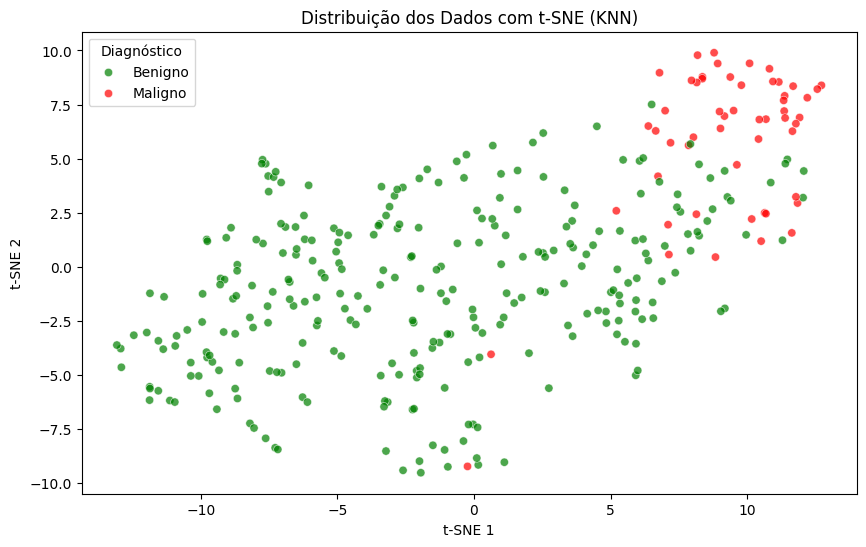

In [31]:
from sklearn.manifold import TSNE

X_tsne_result = TSNE(n_components=2, perplexity=30, max_iter=300, random_state=42).fit_transform(X_train_scaled)

diagnosis_labels = y_train.map({0: 'Benigno', 1: 'Maligno'})

plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=X_tsne_result[:, 0],
    y=X_tsne_result[:, 1],
    hue=diagnosis_labels,
    palette={'Benigno': 'green', 'Maligno': 'red'},
    alpha=0.7
)
plt.title('Distribuição dos Dados com t-SNE (KNN)')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.legend(title='Diagnóstico')
plt.show()

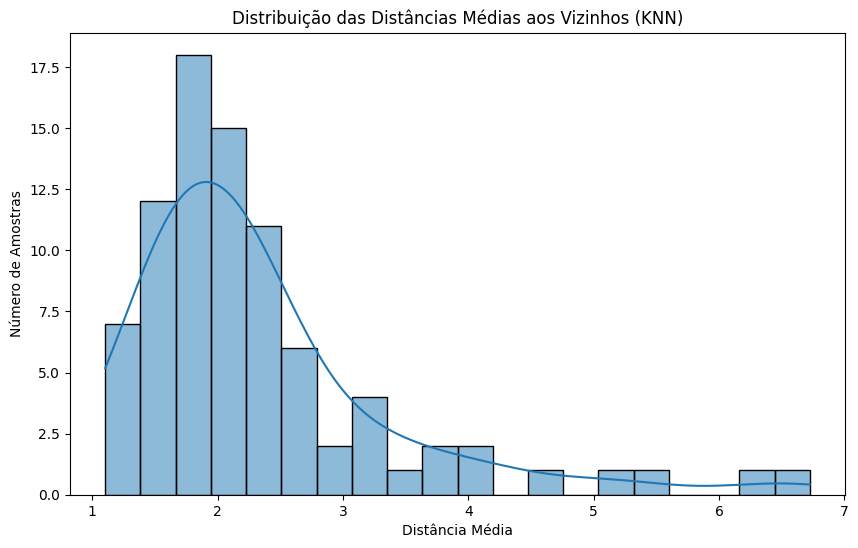

In [32]:
avg_distances = []
for sample in X_test_scaled:
    distances, _ = best_knn.kneighbors(sample.reshape(1, -1))
    avg_distances.append(np.mean(distances))

plt.figure(figsize=(10, 6))
sns.histplot(avg_distances, bins=20, kde=True)
plt.title('Distribuição das Distâncias Médias aos Vizinhos (KNN)')
plt.xlabel('Distância Média')
plt.ylabel('Número de Amostras')
plt.show()

## Resumo:

### Perguntas e Respostas
Com base na análise, o modelo KNN otimizado, com 3 vizinhos e a métrica de distância euclidiana, alcançou a maior precisão (aproximadamente 0,96) no conjunto de teste, superando os classificadores de Regressão Logística, SVM e Árvore de Decisão. A engenharia de recursos, especificamente a criação de recursos de interação e polinomiais, melhorou significativamente o desempenho do modelo. Os avisos iniciais de convergência no modelo de Regressão Logística foram resolvidos com o escalonamento dos dados.

### Principais Conclusões da Análise de Dados
* **Tratamento de Outliers:** Os outliers foram removidos de vários recursos-chave (raio, perímetro, área) usando o método IQR, reduzindo o tamanho do conjunto de dados de 569 para 423 amostras.
* **Engenharia de Recursos:** A criação de recursos de interação e polinomiais melhorou a precisão do modelo em aproximadamente 6%.

* **Comparação de Modelos:** O KNN otimizado (n\_vizinhos = 3, distância euclidiana) superou os classificadores de Regressão Logística, SVM e Árvore de Decisão em termos de precisão no conjunto de teste. O modelo KNN otimizado atingiu uma precisão de aproximadamente 0,94.
* **Escalonamento de Dados:** O escalonamento dos dados usando o MinMaxScaler resolveu os avisos de convergência no modelo de Regressão Logística e melhorou o desempenho de todos os modelos.